In [1]:
import ee
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap.foliumap as geemap
import sys
import folium
import seaborn as sns
import ast

sys.path.append('../../')
sns.set_style()

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch
from src.data.ee_utils import *
from src.data.data_utils import *
from src.data.classes import LUCAS2018_LEVEL2_CODES

ee.Authenticate()
ee.Initialize()

In [2]:
#=========Load Data=========
data_dir = '/scratch/bbug/ayang1/datasets/lucas_fused/csvs'
dataset = []

for ds in os.listdir(data_dir):
    dataset.append(pd.read_csv(os.path.join(data_dir, ds)))

dataset = pd.concat(dataset, axis=0)
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset = dataset.loc[dataset['LABEL']!='NOT_CROP']

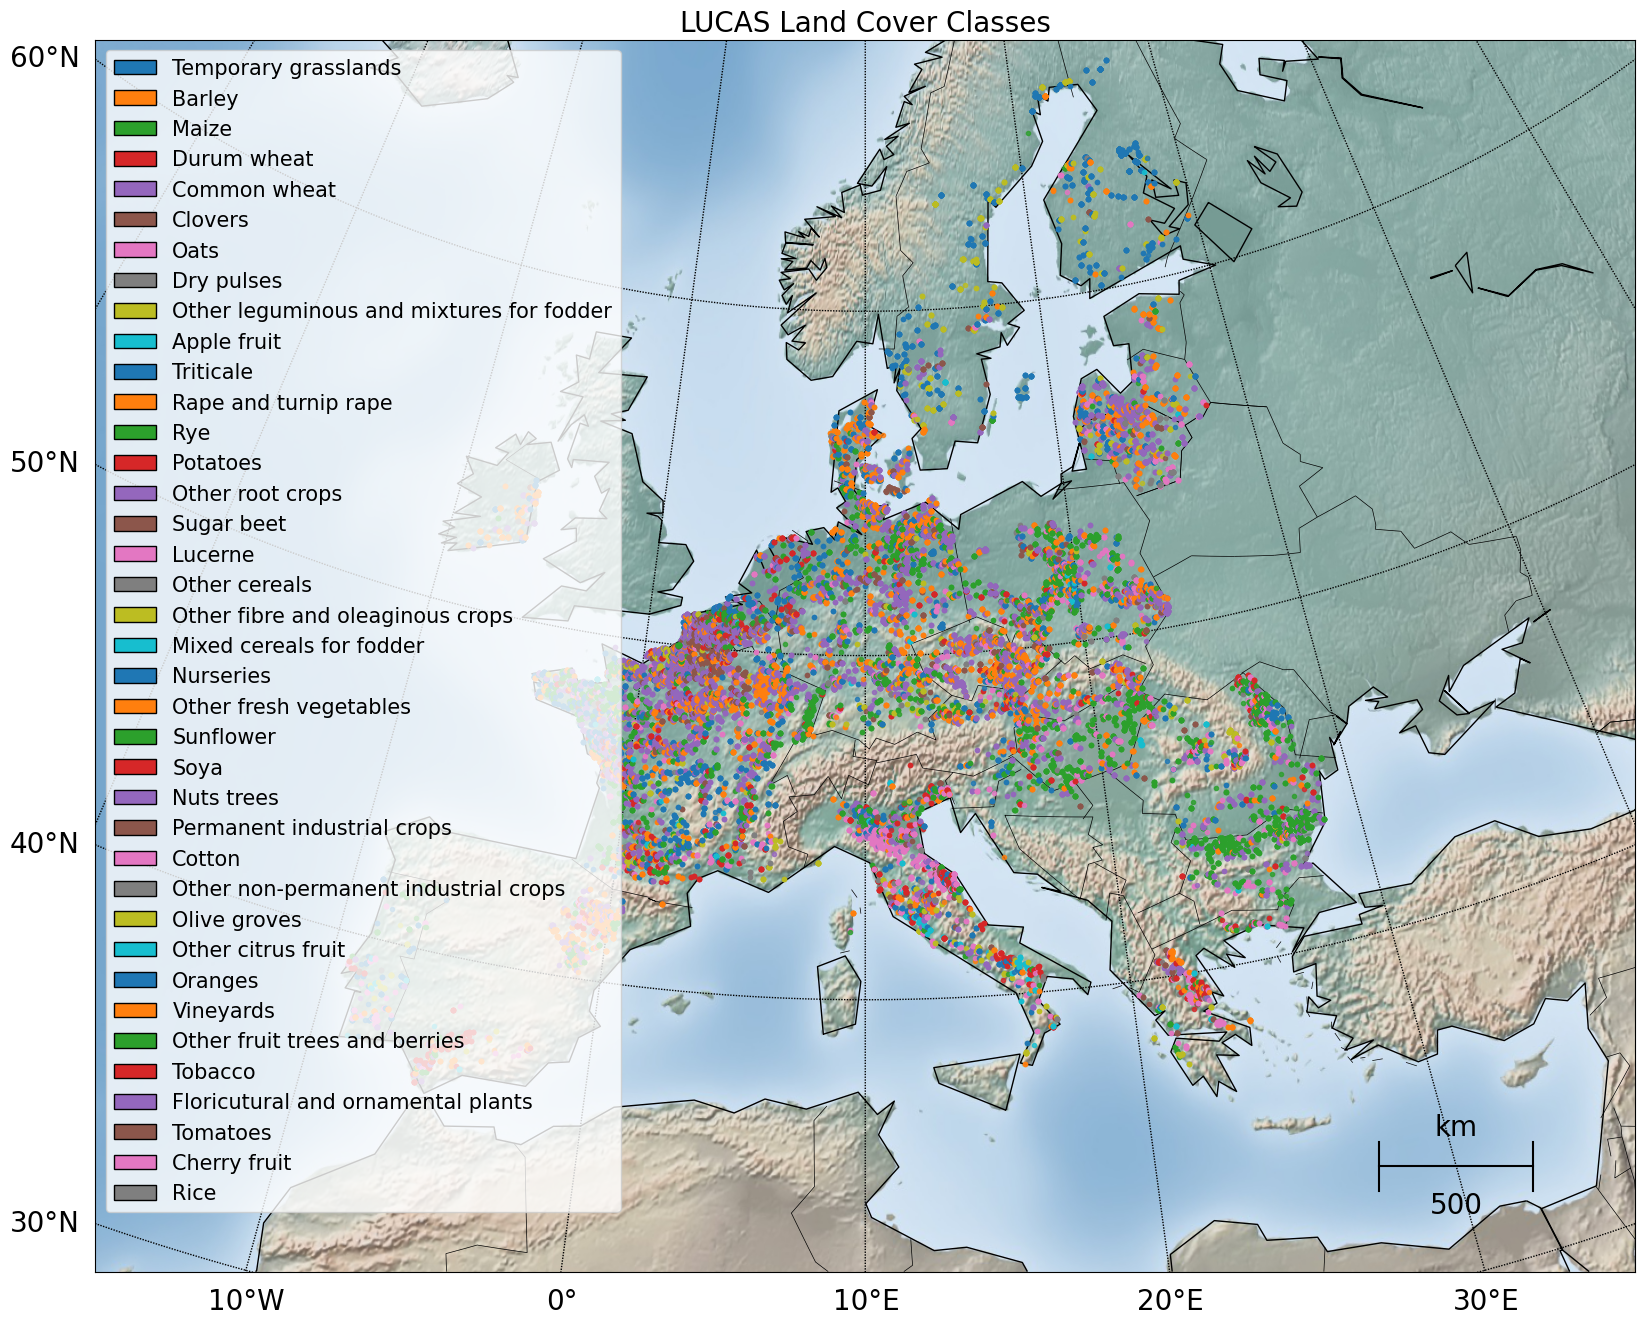

In [3]:
# Create a new figure for Basemap
plt.figure(figsize=(20, 16))
title_font=20
legend_font=15
axis_font=20

#=========Map Setup=========
# Initialize the Basemap for Europe
m = Basemap(projection='lcc', resolution='c', lat_0=50, lon_0=10, width=5E6, height=4E6)
m.drawcountries()
m.drawcoastlines()
m.shadedrelief()

# Draw latitude and longitude lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[True, False, False, False], fontsize=axis_font)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[False, False, False, True], fontsize=axis_font)

# You may need to adjust these values to fit the scale bar within your map
scale_lon = 30  # Adjust this to move the scale bar left or right
scale_lat = 33  # Adjust this to move the scale bar up or down
m.drawmapscale(lon=scale_lon, lat=scale_lat, lon0=10, lat0=50, length=500, barstyle='simple', units='km', fontsize=axis_font)

#=========Plotting=========
cmap = sns.color_palette('tab10', len(dataset['LABEL'].unique()))
colors = {label: cmap[i] for i, label in enumerate(dataset['LABEL'].unique())}

for index, row in dataset.iterrows():
    geom = ast.literal_eval(row['geo'])
    x, y = m(geom['coordinates'][0], geom['coordinates'][1])
    plt.plot(x, y, marker='o',color=colors[row['LABEL']], markersize=3, alpha=0.8)
    
legend_elements = [Patch(facecolor=colors[crop], edgecolor='black',
                     label=LUCAS2018_LEVEL2_CODES[crop]) for crop in colors.keys()]
plt.legend(handles=legend_elements, loc='upper left', fontsize=legend_font)
plt.title('LUCAS Land Cover Classes', fontsize=title_font)
plt.show()
# plt.savefig('./LUCAS_plot.png')

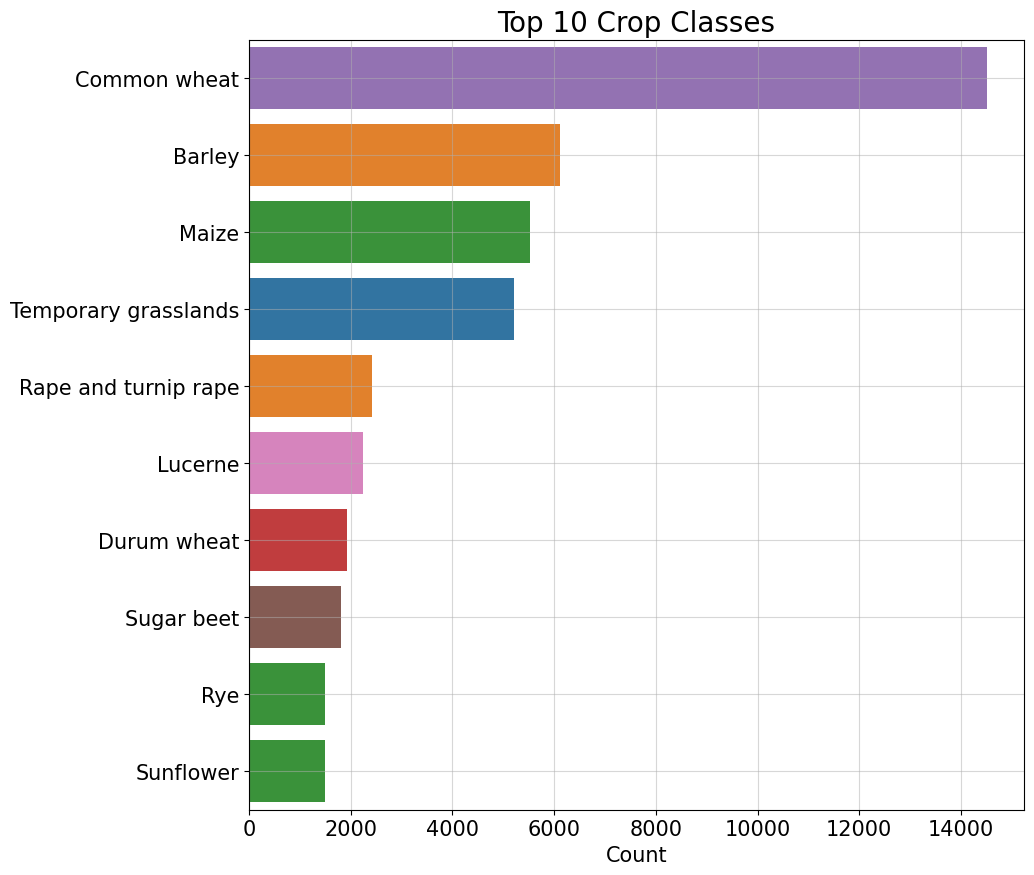

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

plt.figure(figsize=(10, 10))

# Get the unique values and their counts
unique_values, counts = np.unique(dataset['LABEL'], return_counts=True)
count_sort_ind = np.argsort(-counts)
unique_values, counts = unique_values[count_sort_ind][:10], counts[count_sort_ind][:10]
crop_colors = [colors[x] for x in unique_values]

plt.title('Top 10 Crop Classes', fontsize=20)
# Create a bar plot
sns.barplot(y=unique_values, x=counts, orient='h', palette=crop_colors, hue=unique_values)

legend_elements = [Patch(facecolor=colors[crop], edgecolor='black',
                     label=crop) for crop in colors.keys()]

plt.yticks(range(len(unique_values)), [LUCAS2018_LEVEL2_CODES[x] for x in unique_values], fontsize=15)
plt.xticks(fontsize=15)
plt.grid(alpha=0.5)
plt.xlabel('Count', fontsize=15)
plt.show()